### Loading Dataset

In [2]:
import pandas as pd

df = pd.read_csv('Reviews.csv')

print(df.columns)

print(df.head())

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  135077

In [3]:
df_filtered = df[['ProductId', 'Text', 'Score']]
print(df_filtered.head())

    ProductId                                               Text  Score
0  B001E4KFG0  I have bought several of the Vitality canned d...      5
1  B00813GRG4  Product arrived labeled as Jumbo Salted Peanut...      1
2  B000LQOCH0  This is a confection that has been around a fe...      4
3  B000UA0QIQ  If you are looking for the secret ingredient i...      2
4  B006K2ZZ7K  Great taffy at a great price.  There was a wid...      5


### Tokenizing

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "SamLowe/roberta-base-go_emotions"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

print("Model and tokenizer downloaded successfully!")

Model and tokenizer downloaded successfully!


In [5]:
# import pandas as pd
# from transformers import AutoTokenizer

# # Load your Kaggle dataset
# df = pd.read_csv('Reviews.csv')

# # Specify the model name
# model_name = "SamLowe/roberta-base-go_emotions"

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Tokenize the reviews
# def tokenize_reviews(reviews):
#     return tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")

# # Apply the tokenizer to the 'Text' column and store the results
# tokenized_reviews = tokenize_reviews(df['Text'].tolist())

# # Convert the tokenized output to a DataFrame
# tokenized_df = pd.DataFrame({
#     'input_ids': tokenized_reviews['input_ids'].numpy().tolist(),
#     'attention_mask': tokenized_reviews['attention_mask'].numpy().tolist()
# })

# # Save the tokenized DataFrame to a new CSV file
# tokenized_df.to_csv('tokenized_reviews.csv', index=False)

# print("Tokenized output saved to 'tokenized_reviews.csv'.")


In [6]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Load the pre-trained model and tokenizer
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to generate embeddings for the original reviews
def generate_embeddings(text_data):
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    # Process inputs in batches to handle large datasets efficiently
    batch_size = 32  # Adjust based on your available memory
    for i in range(0, len(text_data), batch_size):
        # Get the current batch of reviews
        batch = text_data[i:i + batch_size]
        
        # Tokenize the batch of reviews
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            # Get the model output
            output = model(**encoded_input)
            # Get the embeddings from the last hidden state
            embeddings_batch = output.last_hidden_state[:, 0, :].numpy().tolist()  # [CLS] token embedding
            embeddings.extend(embeddings_batch)

    return embeddings

# Load your Kaggle dataset and take the first 1000 reviews
df = pd.read_csv('Reviews.csv')
text_data = df['Text'].head(1000).tolist()  # Assuming 'review_text' is the column name

# Generate embeddings for the original reviews
embeddings = generate_embeddings(text_data)

# Save the embeddings to a new CSV file
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('embeddings.csv', index=False)

print("Embeddings saved to 'embeddings.csv'.")

Embeddings saved to 'embeddings.csv'.


### Clustering and Visualization

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


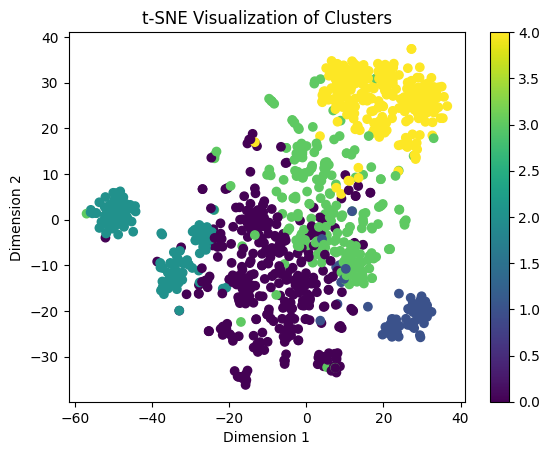

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Number of clusters
num_clusters = 5

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_array)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Plotting the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


### Sentiment Analysis or Emotion Detection

In [3]:
import pandas as pd
from textblob import TextBlob
import re

# Load your dataset (update the path to your CSV file)
df = pd.read_csv('Reviews.csv')  # Ensure 'Reviews.csv' is the correct path to your dataset

# Function to get sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment based on polarity
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Clean the text to remove illegal characters for Excel
def clean_text(text):
    # Remove characters that aren't allowed in Excel
    return re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)

# Applying sentiment analysis on the first 1000 reviews
df['Text'] = df['Text'].apply(clean_text)
df['sentiment'] = df['Text'][:1000].apply(get_sentiment)

# Save the results to a new Excel file
output_file = 'sentiment_analysis_results.xlsx'
df[['Text', 'sentiment']].to_excel(output_file, index=False, engine='openpyxl')

print(f"Sentiment analysis results have been saved to {output_file}.")


Sentiment analysis results have been saved to sentiment_analysis_results.xlsx.


### Retrieval-Augmented Generation (RAG) System

In [ ]:
# from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration
# from datasets import load_dataset
# import torch

# # Load the knowledge base dataset (you can use your own)
# # For demonstration, using the 'wiki_dpr' dataset as a knowledge base
# dataset = load_dataset("wiki_dpr", "psgs_w100", split="train[:1000]")  # Limit for demo purposes

# # Initialize the retriever
# tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-nq")
# retriever = RagRetriever.from_pretrained(
#     "facebook/rag-token-nq",
#     index_name="legacy",  # Default index name
#     use_dummy_dataset=True  # Use a dummy dataset in this example
# )

# # Initialize the RAG model (sequence style)
# model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq")

# # Tokenize the input question/query
# input_text = "What is the capital of France?"
# input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"]

# # Retrieve relevant documents from the knowledge base
# retriever_results = retriever(input_ids, return_tensors="pt")

# # Generate an answer using the retrieved documents
# outputs = model.generate(input_ids=input_ids, context_input_ids=retriever_results["context_input_ids"])

# # Decode and print the result
# generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
# print(f"Generated answer: {generated_text[0]}")

# # To check retrieved documents
# retrieved_docs = retriever_results["doc_ids"]
# print("Retrieved documents:", retrieved_docs)


### Integrate with Pinecone or Another Vector Database

In [10]:
import faiss
import numpy as np

# Assuming 'embeddings' is a list of NumPy arrays or a 2D NumPy array with shape (N, 1536)
# Convert 'embeddings' to a NumPy array if it's not already
embeddings = np.array(embeddings)

# Step 1: Build the FAISS index
dimension = embeddings.shape[1]  # Dimensionality of embeddings (should be 1536)
index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean)

# Step 2: Add the embeddings to the index
index.add(embeddings)

# Step 3: Perform a search
def search_reviews(query_embedding, top_k=5):
    # Reshape the query_embedding to a 2D array as required by FAISS
    query_embedding = np.array(query_embedding).reshape(1, -1)
    # Perform the search using FAISS's search method
    distances, indices = index.search(query_embedding, top_k)
    # Prepare results in a list of dictionaries
    results = [{"id": int(indices[0][i]), "score": float(distances[0][i])} for i in range(top_k)]
    return results

# Example: Search for the top 5 similar reviews to the first review
similar_reviews = search_reviews(embeddings[0])
for match in similar_reviews:
    print(f"ID: {match['id']}, Score: {match['score']}")


ID: 0, Score: 0.0
ID: 54, Score: 18797436.0
ID: 320, Score: 18797572.0
ID: 358, Score: 18797624.0
ID: 972, Score: 18797740.0


### Fine-Tuning the Model for Better Performance

In [18]:
import torch
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Load your dataset
df = pd.DataFrame({
    'Text': ['Sample review text 1', 'Sample review text 2', 'Sample review text 3'] * 334,  # Example data
    'HelpfulnessNumerator': [1, 0, 1] * 334  # Example labels
})

# Limit to the first 1000 samples
df = df[:1000]

# Use DistilBERT tokenizer for encoding the texts
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Splitting the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Text'], df['HelpfulnessNumerator'], test_size=0.2, random_state=42
)

# Convert texts to format expected by transformers
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Create a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = CustomDataset(train_encodings, train_labels.tolist())
test_dataset = CustomDataset(test_encodings, test_labels.tolist())

# Model initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Move model to the MPS device
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Define a custom collate function to move data to the correct device
def data_collator(features):
    batch = {key: torch.stack([f[key] for f in features]) for key in features[0]}
    return {k: v.to(device) for k, v in batch.items()}

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

# Train the model
trainer.train()


Using device: mps


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.

RuntimeError: Placeholder storage has not been allocated on MPS device!

### Building an Application Interface

In [ ]:
! pip install transformers[torch]

In [ ]:
! pip install accelerate -U

In [ ]:
import streamlit as st

# Simple Streamlit app to search for reviews
st.title('Review Search App')

query = st.text_input('Enter your query:')

if query:
    # Example embedding of the query (you may need to generate embeddings for the input)
    query_embedding = model.encode(query)

    # Search the Pinecone index
    results = search_reviews(query_embedding)

    # Display the top results
    st.write('Top similar reviews:')
    for result in results:
        st.write(f"ID: {result['id']}, Score: {result['score']}")
